# Questao 1

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


def carregar_dados_imdb():
    """Carrega o dataset de reviews positivos e negativos do IMDb."""
    reviews_train = load_files("aclImdb/train/", categories=['pos', 'neg'], encoding='utf-8', random_state=42)
    reviews_test = load_files("aclImdb/test/", categories=['pos', 'neg'], encoding='utf-8', random_state=42)
    return reviews_train.data, reviews_train.target, reviews_test.data, reviews_test.target


def redimensionar_texto_tfidf(textos_treino, vetor_config):
    """Converte texto em matriz TF-IDF e retorna a forma (dimensão) e o vetorizador."""
    vetor = TfidfVectorizer(**vetor_config)
    matriz = vetor.fit_transform(textos_treino)
    print(f"\n[1] Redimensionamento de features com TF-IDF:")
    print(f"- Número de documentos: {matriz.shape[0]}")
    print(f"- Número de features (palavras/ngramas): {matriz.shape[1]}")
    print(f"- Primeiras 10 features: {vetor.get_feature_names_out()[:10]}")
    return vetor, matriz


X_train, y_train, X_test, y_test = carregar_dados_imdb()

vetor_config = {"min_df": 5, "stop_words": "english", "ngram_range": (1, 2)}
vetor, matriz = redimensionar_texto_tfidf(X_train, vetor_config)


[1] Redimensionamento de features com TF-IDF:
- Número de documentos: 20476
- Número de features (palavras/ngramas): 66970
- Primeiras 10 features: ['00' '000' '000 00' '000 000' '000 budget' '000 feet' '000 year'
 '000 years' '007' '01']


# Questao 2


In [22]:
def exibir_extremos_tfidf(vetor, textos_treino, top_n=10):
    """Exibe as features com os maiores e menores valores máximos de TF-IDF no conjunto de treino."""
    matriz_tfidf = vetor.transform(textos_treino)
    max_tfidf = matriz_tfidf.max(axis=0).toarray().ravel()
    feature_names = np.array(vetor.get_feature_names_out())
    indices_ordenados = max_tfidf.argsort()[::-1]

    print(f"\n[1.5] Top {top_n} features com maiores valores de TF-IDF:")
    for idx in indices_ordenados[:top_n]:
        print(f"{feature_names[idx]}: {max_tfidf[idx]:.4f}")

    print(f"\n[1.5] Top {top_n} features com menores valores de TF-IDF:")
    for idx in indices_ordenados[-top_n:]:
        print(f"{feature_names[idx]}: {max_tfidf[idx]:.4f}")


exibir_extremos_tfidf(vetor, X_train)



[1.5] Top 10 features com maiores valores de TF-IDF:
pokemon: 0.8860
doodlebops: 0.8533
casper: 0.8497
raj: 0.8227
dev: 0.8164
zizek: 0.8116
darkman: 0.8074
demons: 0.7975
joan: 0.7857
zatoichi: 0.7837

[1.5] Top 10 features com menores valores de TF-IDF:
seven dwarfs: 0.0668
enrico ratso: 0.0656
snake like: 0.0651
supposed budget: 0.0650
horace: 0.0647
scene stealing: 0.0639
vampire cloak: 0.0639
intercontinental: 0.0629
literally br: 0.0600
stubbornly: 0.0596


# Questão 3:


In [23]:

def treinar_classificador(textos_treino, y_treino, textos_teste, y_teste):
    """Executa GridSearch com Regressão Logística e retorna o modelo treinado."""
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(min_df=5, stop_words="english", ngram_range=(1, 2))),
        ("logreg", LogisticRegression(max_iter=1000))
    ])

    param_grid = {
        "logreg__C": [0.001, 0.01, 0.1, 1, 10],
        "tfidf__ngram_range": [(1, 1), (1, 2)]
    }

    print("\n[2] Treinando Regressão Logística com validação cruzada...")
    grid = ç(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid.fit(textos_treino, y_treino)

    print(f"\n- Melhor pontuação de validação cruzada: {grid.best_score_:.2f}")
    print(f"- Melhores parâmetros: {grid.best_params_}")

    acuracia = grid.score(textos_teste, y_teste)
    print(f"- Precisão final no conjunto de teste: {acuracia:.2f}")

    return grid


modelo = treinar_classificador(X_train, y_train, X_test, y_test)


[2] Treinando Regressão Logística com validação cruzada...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

- Melhor pontuação de validação cruzada: 0.89
- Melhores parâmetros: {'logreg__C': 10, 'tfidf__ngram_range': (1, 2)}
- Precisão final no conjunto de teste: 0.88


# Questão 4 - Crie um gráfico de barras

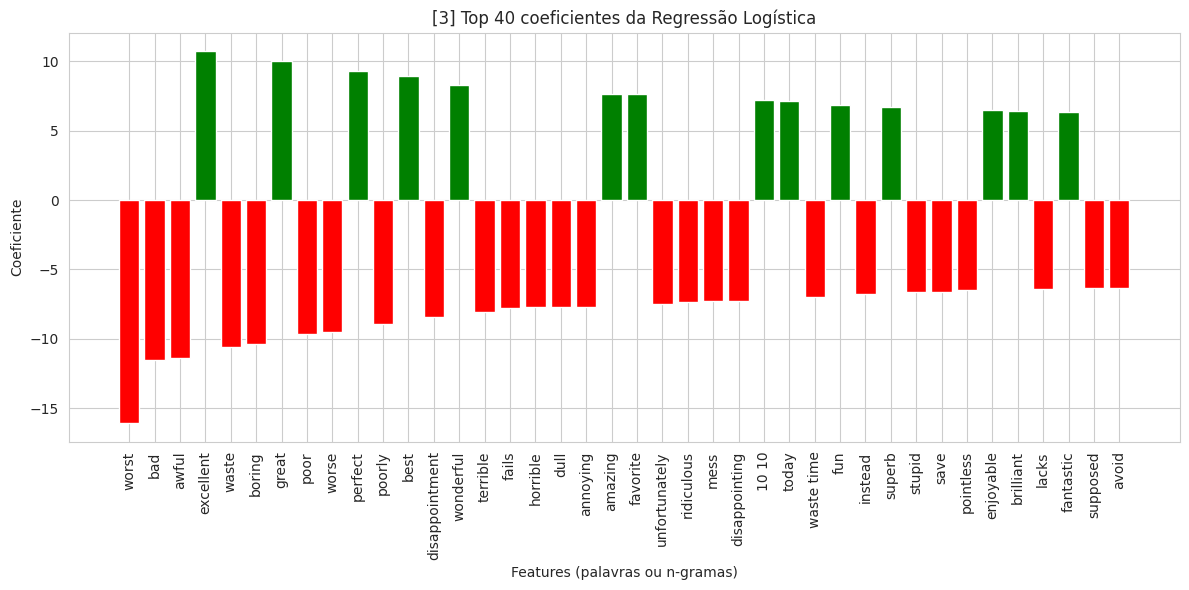

In [24]:

def exibir_maiores_coeficientes(modelo, top_n=40):
    """Exibe gráfico de barras com os maiores coeficientes da Regressão Logística."""
    vetor = modelo.best_estimator_.named_steps["tfidf"]
    regressao = modelo.best_estimator_.named_steps["logreg"]

    feature_names = np.array(vetor.get_feature_names_out())
    coef = regressao.coef_.ravel()
    indices_ordenados = np.argsort(np.abs(coef))[::-1]

    top_features = feature_names[indices_ordenados[:top_n]]
    top_coefs = coef[indices_ordenados[:top_n]]

    plt.figure(figsize=(12, 6))
    cores = ['green' if c > 0 else 'red' for c in top_coefs]
    plt.bar(range(top_n), top_coefs, color=cores)
    plt.xticks(range(top_n), top_features, rotation=90)
    plt.title("[3] Top 40 coeficientes da Regressão Logística")
    plt.xlabel("Features (palavras ou n-gramas)")
    plt.ylabel("Coeficiente")
    plt.tight_layout()
    plt.show()


exibir_maiores_coeficientes(modelo)